Versions of some packages installed on my computer are different from what they have on kaggle, that's why output of this notebook has slightly different scores from what you've seen on the leaderboard. However, that's close version of notebook that gave me submission with private LB score 564855.334.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgbm

In [2]:
os.listdir('../input/')

['infopulsehackathon']

In [3]:
sns.set(style = 'darkgrid', palette = 'spring')

pd.set_option('display.max_columns', 400)
pd.set_option('max_rows', 1000)

## Load data

In [4]:
DATA_FOLDER = '../input/infopulsehackathon/'
SUBMISSIONS_FOLDER = ''
os.listdir(DATA_FOLDER)

['test.csv', 'train.csv', 'sample_submission.csv']

In [5]:
df  = pd.read_csv(DATA_FOLDER+'train.csv', index_col='Id')
df.shape

(4000, 286)

In [6]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,Energy_consumption
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4,10,MT,A,2,1,0,0,-2,10,0,-2,2,1,8,-2,3,1,0,2,5,2,1,0,0,30,1,1,3,4,1,0,-2,-2,-2,0,-2,-2,0,0,0,1,4,23,2,0,-2,-2,-2,-2,0,-2,-2,-2,1,1,-2,-2,14,0,0,-2,-2,0,-2,-2,1,25,1,2,3,0,0,0,0,0,0,0,0,0,-2,-2,-2,0,-2,-2,-2,-2,-2,0,-2,-2,-2,4,3,1,2,3,1,1,2,2,1,0,0,1,0,0,0,0,0,0,1,0,4,0,1,0,1,-2,3,1,2,1,1,1,65,60,55,0,-2,-2,0,-2,-2,0,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,

In [7]:
target = 'Energy_consumption'

## EDA

In [8]:
df.isna().any().any()

False

Luckily, there are no NAs :)

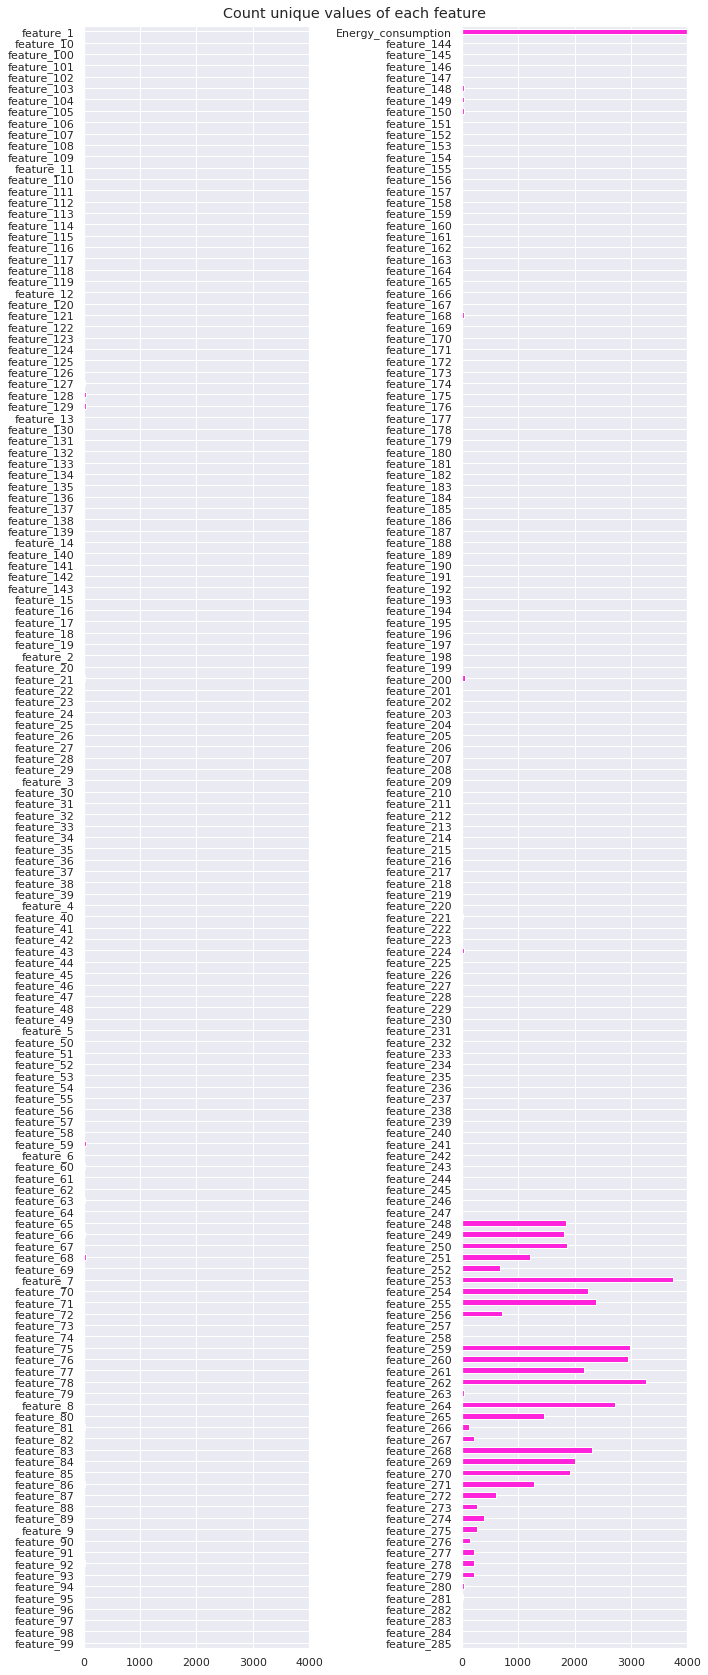

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10, 25))
df.nunique()[:(df.shape[1] // 2):].sort_index(ascending=False).plot(kind='barh', ax = ax[0])
df.nunique()[(df.shape[1] // 2):].sort_index(ascending=False).plot(kind='barh', ax = ax[1])
ax[0].set_xlim(0, 4000)
ax[1].set_xlim(0, 4000)
fig.suptitle('Count unique values of each feature');
fig.tight_layout(rect=[0, 0.05, 1, 0.98])

In [10]:
print('Stats of unique values number:')
df.nunique().describe()

Stats of unique values number:


count     286.000000
mean      168.181818
std       601.642998
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max      3986.000000
dtype: float64

Looks like most features have just a few unique values thus they might be categorical even if they are represented as numeric variables.

Lets look at the features that are not numeric for sure.

In [11]:
df.select_dtypes(exclude = np.number)

,feature_3,feature_4,feature_257,feature_258
Id,,,,
0,MT,A,MR,3C
1,MC,B,HH,3A
2,MT,A,HD,2B
3,MT,C,MH,4A
4,MT,A,HD,3B-4B
...,...,...,...,...
3995,MT,C,VC,6A-6B
3996,MT,A,VC,5B-5C
3997,MC,C,MR,4C


In [12]:
print('Number of unique values:')
df.select_dtypes(exclude = np.number).nunique()

Number of unique values:


feature_3       3
feature_4       3
feature_257     5
feature_258    11
dtype: int64

## Feature selection

We have large amount of features, but doubt all of them should be included modeling dataset. 
Several steps were followed to decrease number of features:
- try to get rid of multicollinearity (high intercorrelations  between independent variables). Even though LightGBM is known to be robusted to such a thing, highly intercorrelated features make no good as well - they simply do not provide model with new information. sklearn.feature_selection.VarianceThreshold is used to remove similar variables
- exclude variables that have only one unique value

In [13]:
var_cuter = VarianceThreshold(threshold=0.1)
df_var = df.drop(target, axis=1).select_dtypes(np.number)
var_mask = var_cuter.fit(df_var).get_support()
var_drop_cols = df_var.iloc[:,var_mask==False].columns.tolist()

print('low-variance features:')
var_drop_cols

low-variance features:


['feature_36',
 'feature_67',
 'feature_76',
 'feature_119',
 'feature_210',
 'feature_223',
 'feature_226',
 'feature_231',
 'feature_237',
 'feature_238',
 'feature_239',
 'feature_240',
 'feature_241',
 'feature_242',
 'feature_263',
 'feature_280']

In [14]:
print('Features that have single value')
df.nunique()[df.nunique()<2]

Features that have single value


feature_226    1
feature_231    1
dtype: int64

In [15]:
drop_cols = df.nunique()[df.nunique()<2].index.tolist()
drop_cols += var_drop_cols
print(f'{len(drop_cols)} features will be droped:')
drop_cols

18 features will be droped:


['feature_226',
 'feature_231',
 'feature_36',
 'feature_67',
 'feature_76',
 'feature_119',
 'feature_210',
 'feature_223',
 'feature_226',
 'feature_231',
 'feature_237',
 'feature_238',
 'feature_239',
 'feature_240',
 'feature_241',
 'feature_242',
 'feature_263',
 'feature_280']

## Categorical features

We have already seen that feature_3, feature_4, feature_257, feature_258 are string type thus they are categorical for sure.
I also assume that there are more features that are categorical but represented as numeric features. Of course, I cannot prove it and I'm not sure that my assumption is right, but I tried to treat features with low number of unique values as categorical ones and that slightly improved performance.

In [16]:
cat_cols = df.select_dtypes(exclude= np.number).columns.tolist() # feature_3, feature_4, feature_257, feature_258
cat_cols += df.nunique()[df.nunique() < 5].index.tolist() # features that have less that n unique values
cat_cols = [col for col in cat_cols if col not in drop_cols]
cat_cols = list(set(cat_cols))
len(cat_cols)

112

## Model training

#### RepeatedKFold. 
Started from simple KFold with 5 folds (also tried 4 and 10 folds), than switched to RepeatedKFold with 5 folds and 10 repeats. So, 5x10=50 models are used for prediction which is complete overkill:) But I wanted to be sure that performance of the models is stable and does not depend on random state. Also, I decided to use this approarch instead of blending because it's easier. StratifiedKfold with stratification along target quartiles did not improve public score in my case (tried with a few different random states); even though standard deviation of validation set is smaller with StratifiedKfold it might be because train and validation sets have similar distributions and not because models performance gets better. 
#### LightGBM. 
I didn't expect that such an exhaustive LightGBM (300000 iterations and learning rate 0.0005) will give me the best performance on such a small dataset. However, I ended up with this model.

In [17]:
X = df.drop([target]+drop_cols, axis=1)
y = df[target]

In [18]:
n_splits=5
n_repeats=10

num_iter = 300000
early_stopping_rounds = 10000
verbose = 10000

lgb_params = {
    'learning_rate': 0.0005,
    'num_leaves': 15,
    'feature_fraction': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 8,
    'application': 'regression',
    'metric': ['mse'],
    'num_threads': -1,
    'seed': 42}


In [19]:
models = []

kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

k=0
for train_ids, val_ids in tqdm(kf.split(X), desc='KFold', total=n_splits*n_repeats):
    k+=1
    print(f'\nFOLD {k}')
    print(dt.datetime.now().time())
    X_train, y_train = X.iloc[train_ids].copy(), y.iloc[train_ids]
    X_val, y_val = X.iloc[val_ids].copy(), y.iloc[val_ids]

    X_train[cat_cols] = X_train[cat_cols].astype('category')
    X_val[cat_cols] = X_val[cat_cols].astype('category')

    lgb_train = lgbm.Dataset(X_train, y_train)
    lgb_eval = lgbm.Dataset(X_val, y_val)

    lgb = lgbm.train(lgb_params,
                lgb_train,
                num_boost_round=num_iter,
                valid_sets=(lgb_train, lgb_eval),
                valid_names=('train', 'val'),
               early_stopping_rounds=early_stopping_rounds,
               verbose_eval = verbose)
    
    models.append(lgb)



FOLD 1
14:16:07.501746
Training until validation scores don't improve for 10000 rounds
[10000]	train's l2: 476810	val's l2: 616916
[20000]	train's l2: 327741	val's l2: 582881
[30000]	train's l2: 248103	val's l2: 572352
[40000]	train's l2: 194131	val's l2: 568392
[50000]	train's l2: 154457	val's l2: 566675
[60000]	train's l2: 124465	val's l2: 566386
Early stopping, best iteration is:
[58011]	train's l2: 129799	val's l2: 566256

FOLD 2
14:18:39.530866
Training until validation scores don't improve for 10000 rounds
[10000]	train's l2: 488727	val's l2: 622924
[20000]	train's l2: 336871	val's l2: 574235
[30000]	train's l2: 255147	val's l2: 561093
[40000]	train's l2: 199739	val's l2: 555174
[50000]	train's l2: 159285	val's l2: 552157
[60000]	train's l2: 128598	val's l2: 550570
[70000]	train's l2: 104783	val's l2: 549774
[80000]	train's l2: 86081.5	val's l2: 549336
[90000]	train's l2: 71146.1	val's l2: 549210
Early stopping, best iteration is:
[88570]	train's l2: 73084.8	val's l2: 549122

FO

In [20]:
def get_score_lgb(model, name='val'):
    return list(model.best_score[name].values())[0]

train_scores = np.array([get_score_lgb(model, 'train') for model in models])
val_scores = np.array([get_score_lgb(model, 'val') for model in models])

print('mean train score: {:.0f}+-{:.0f}'.format(train_scores.mean(), train_scores.std()))
print('min {:.0f}; max {:.0f}\n'.format(train_scores.min(), train_scores.max()))
print('mean validation score: {:.0f}+-{:.0f}'.format(val_scores.mean(), val_scores.std()))
print('min {:.0f}; max {:.0f}\n'.format(val_scores.min(), val_scores.max()))

mean train score: 89804+-55837
min 4284; max 224780

mean validation score: 617345+-57764
min 510953; max 781231



In [21]:
# lgbm.plot_importance(models[0], importance_type='gain', figsize=(5,40), ignore_zero=False)

### Submission

In [22]:
df_test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')

df_test.shape

(1686, 285)

In [23]:
df_test.drop(drop_cols, axis=1, inplace=True)

In [24]:
df_test[cat_cols] = df_test[cat_cols].astype('category')

In [25]:
predictions = np.array([model.predict(df_test, num_iter=model.best_iteration) for model in models]).mean(axis=0)

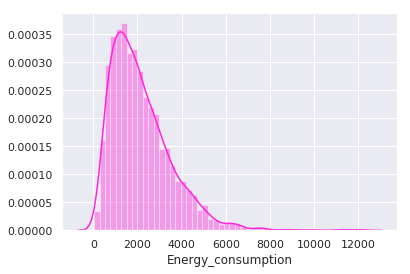

In [26]:
sns.distplot(y)

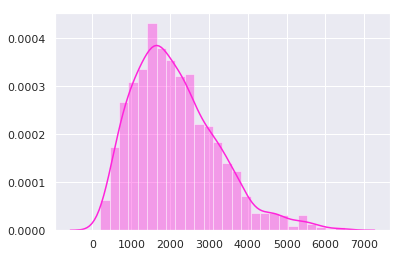

In [27]:
sns.distplot(predictions)

In [28]:
submission = pd.DataFrame({
    'Id': df_test.index,
    'Energy_consumption': predictions
})

In [29]:
submission.to_csv(SUBMISSIONS_FOLDER + 'submission.csv', index = False)